Constructed 8 bins with expected >=20, df=7


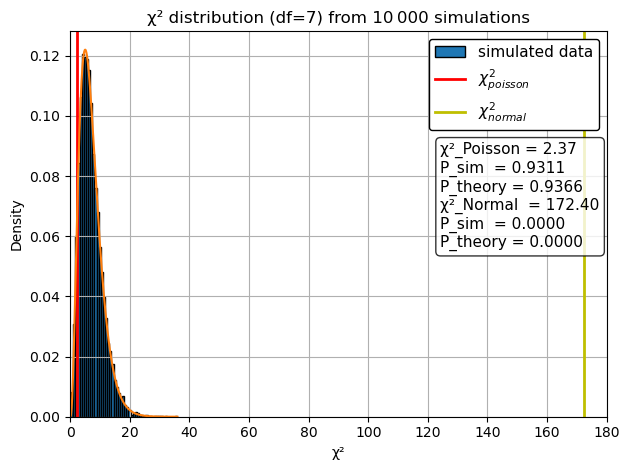

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Parameters
lam = 2.47
N_events = 6614
N_sim = 10_000
df = 7
chi2_cut_poisson = 2.37
chi2_cut_normal= 172.4
rng = np.random.default_rng(seed=42)

# Build 9 bins, each expected >=20
max_k = int(stats.poisson.ppf(0.999999, lam)) + 10
exp_counts_k = stats.poisson.pmf(np.arange(max_k + 1), lam) * N_events

bins = []
current = []
accum = 0.0
for k in range(max_k + 1):
    current.append(k)
    accum += exp_counts_k[k]
    if accum >= 20 and len(bins) < df:   # create first 32 bins
        bins.append(tuple(current))
        current, accum = [], 0.0
# remainder to last bin
if current:
    bins.append(tuple(current))

while len(bins) < df + 1:
    bins.append(tuple())
assert len(bins) == df + 1, f"Got {len(bins)} bins, expected 19"

exp_counts_bin = np.array([exp_counts_k[list(b)].sum() if b else 0.0 for b in bins])
# Merge empty bins with previous to keep expected >=20
for i in range(len(exp_counts_bin)):
    if exp_counts_bin[i] < 20:
        # merge with previous
        exp_counts_bin[i-1] += exp_counts_bin[i]
        bins[i-1] = bins[i-1] + bins[i]
        exp_counts_bin[i] = 0
# Remove zeros if any and adjust df
nonzero_mask = exp_counts_bin >= 20
bins = [b for b, m in zip(bins, nonzero_mask) if m]
exp_counts_bin = exp_counts_bin[nonzero_mask]
n_bins = len(bins)
df = n_bins - 1

print(f"Constructed {n_bins} bins with expected >=20, df={df}")

# Mapping k to bin
k_to_bin = np.full(max_k + 1, n_bins - 1, dtype=int)
for idx, ks in enumerate(bins):
    for k in ks:
        k_to_bin[k] = idx


def chi2_batch(samples):
    mapped = k_to_bin[samples.clip(max=max_k)]
    batch = samples.shape[0]
    counts = np.zeros((batch, n_bins), dtype=int)
    for b in range(n_bins):
        counts[:, b] = np.sum(mapped == b, axis=1)
    chi2 = np.sum((counts - exp_counts_bin)**2 / exp_counts_bin, axis=1)
    return chi2

# Monte Carlo 
chi2_vals = np.empty(N_sim)
chunk = 200
i = 0
while i < N_sim:
    n = min(chunk, N_sim - i)
    chi2_vals[i:i+n] = chi2_batch(rng.poisson(lam, size=(n, N_events)))
    i += n

# Probabilities 
p_sim_poisson = np.mean(chi2_vals > chi2_cut_poisson)
p_sim_normal  = np.mean(chi2_vals > chi2_cut_normal)
p_th_poisson  = 1 - stats.chi2.cdf(chi2_cut_poisson, df=df)
p_th_normal   = 1 - stats.chi2.cdf(chi2_cut_normal,  df=df)

# Plot 
plt.figure()
plt.hist(chi2_vals, bins=50, density=True, edgecolor='black',label='simulated data')
plt.xlim(0,180)
plt.axvline(chi2_cut_poisson, linestyle='-',linewidth=2,color='r',label=r'$\chi^2_{poisson}$')
plt.axvline(chi2_cut_normal, linestyle='-',linewidth=2,color='y',label=r'$\chi^2_{normal}$')
plt.legend(fontsize=11, loc='upper right', frameon=True, 
           facecolor='white', edgecolor='black', framealpha=1, labelcolor='black')
plt.grid()

x = np.linspace(0, chi2_vals.max(), 400)
plt.plot(x, stats.chi2.pdf(x, df=7), lw=1.5)
plt.title("χ² distribution (df=7) from 10 000 simulations")
plt.xlabel("χ²")
plt.ylabel("Density")

# Text box with probabilities
textstr = (f"χ²_Poisson = {chi2_cut_poisson:.2f}\n"
           f"P_sim  = {p_sim_poisson:.4f}\n"
           f"P_theory = {p_th_poisson:.4f}\n"
           f"χ²_Normal  = {chi2_cut_normal:.2f}\n"
           f"P_sim  = {p_sim_normal:.4f}\n"
           f"P_theory = {p_th_normal:.4f}")
plt.text(0.69, 0.44, textstr, transform=plt.gca().transAxes,fontsize=11,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("2kbar(180)_Monte.png", dpi=300)
plt.show()